### Getting Low-Res Gram Matrix from a image

## All the libraries + CNN model

In [14]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image
from skimage.transform import resize

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


# Download the model
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn = cnn.to(device)

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


## Image Loader (from the starter code)
You can also use your own image loader, that's probably easier

In [15]:
# Dataloader
imsize = 512

SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
                transforms.Resize(imsize),
                transforms.ToTensor(),
                transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(), std=SQUEEZENET_STD.tolist()),
                transforms.Lambda(lambda x: x[None]),
                ])
    image = transform(image)
    return image.to(device, torch.float)

# visualizing the content and style images

# Commented Out to load Artbench Style instead
# style_img = image_loader("styles/muse.jpg", imsize)
# content_img = image_loader("contents/000000211825.jpg", imsize)
style_img = image_loader("artbench_styles/expressionism/antonietta-raphael_caltagirone-all-alba-1951.jpg", imsize)
content_img = image_loader("artbench_styles/art_nouveau/a-y-jackson_grey-day-laurentians-1928.jpg", imsize)

def deprocess(img):
    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x[0]),
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
            transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
            transforms.Lambda(lambda x: x),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

## Get Feature Map

In [16]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = []
    in_feat = x
    for layer in cnn._modules.values():
        out_feat = layer(in_feat)
        feats.append(out_feat)
        in_feat = out_feat
    return feats

## Gram Matrix

In [17]:
def gram_matrix(feat, normalize = True):
    """
    Compute the gram matrix.
    
    Inputs:
    - feat: a feature tensor of shape (1, C, H, W).
    - normalize: if normalize is true, divide the gram matrix by C*H*W:
    Returns
    - gram: the gram matrix
    """

    gram = None

    ###########################################################################
    # TODO: Implement the gram matrix. You should not use a loop or           #
    # comprehension                                                           #
    ###########################################################################
    
    #gram = torch.einsum('kij,lij->kl',feat,feat) #the gram matrix implementation
    #Do I need to do to C,H,W here? or that's only for normalize
    #What happens to the 1 in the shape in the front?
    # or we can try flatten feat, then do matrix multiplication with transpose
    
    N, C, H, W = feat.size()
    feat = feat.view(feat.size(1), -1)
    gram = torch.mm(feat, feat.t())
    
    if(normalize):
        #normalize if true
        gram = gram / (C*H*W)
    
    pass

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return gram

## Plotting Low-Res Gram matrix (16 * 16)
They are also turned into a numpy array

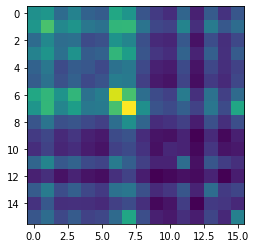

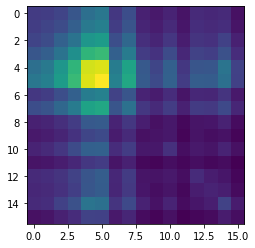

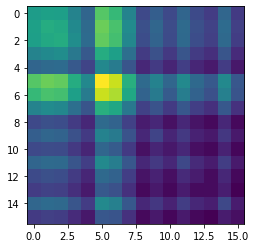

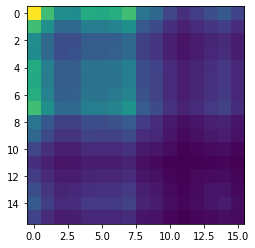

<Figure size 432x288 with 0 Axes>

In [18]:
    ######TODO::: Replace directory to the artbench directory
    ## Also change size to 256, the size of image in the dataset
    ## you can also change to your own image loader
    style_img = image_loader('artbench_styles/others/starry_night.jpg', 512)
    
    #this step gets the features and style targets
    feats = get_feature_maps(style_img, cnn)
    style_targets = []
    for idx in [1,4,6,7]:
         style_targets.append(gram_matrix(feats[idx].clone()))

    # this step loops through the 4 element in the array and resize them to 16*16
    for i in range (0,4):
        array = style_targets[i].numpy()
#         plt.imshow(array)
#         plt.figure()
        array_lowres = resize(array, (16, 16),
                          anti_aliasing=True)
        plt.imshow(array_lowres)
        plt.figure()